In [166]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

## Optimizing q for Exponential Holder Bound

In [360]:
def A(t, n):
    return n * np.sum(np.maximum(t, 0) + np.log(1 + np.exp(-np.abs(t))))
    
def dA(t, n):
    return n * jax.nn.sigmoid(t)
    
def A_cp(t, n):
    return n * cp.sum(cp.logistic(t))

def opt_q_cp(n, theta_0, v, a):
    A0 = A(theta_0, n)
    q = cp.Variable(pos=True)
    objective_fn = (
        (A_cp(theta_0 + (q+1) * v, n) - A0)
        + a
    ) / (q + 1)
    objective = cp.Minimize(objective_fn)
    problem = cp.Problem(objective)
    problem.solve(qcp=True)
    return q.value + 1
    
def phi_t(q, t, n, theta_0, v):
    '''
    Computes phi_t(q) defined as
        A(theta_0 + qv) - tq 
    '''
    return A(theta_0 + q * v, n) - t * q
    
def dphi_t(q, t, n, theta_0, v):
    '''
    Computes dphi_t(q)/dq given by
        A'(theta_0 + qv)^T v - t
    '''
    return jnp.sum(dA(theta_0 + q*v, n) * v) - t
    
def convex_feasible(t, n, theta_0, v, bound, u0=10, tol=1e-6, max_iters=100):
    '''
    We say phi_t(q) is feasible if there exists q >= 1
    such that phi_t(q) <= A(theta_0) - a.
    To unconstrain the minimization problem, we parametrize q = 1 + e^u.

    Assumes that u0 > tol.

    Returns True if phi_t(q) is feasible.
    '''
    def transform(u):
        return 1 + jnp.exp(u)
        
    def dtransform(u):
        return jnp.exp(u)

    u_prev = 0
    q_prev = 2
    dphi_t_u_prev = dphi_t(q_prev, t, n, theta_0, v)

    u = u0
    q = transform(u)
    phi_t_u = phi_t(q, t, n, theta_0, v)
    dphi_t_u = dphi_t(q, t, n, theta_0, v) * dtransform(u)

    iter = 0
    while (phi_t_u > bound) and (jnp.abs(u - u_prev) > tol) and (iter < max_iters):
        # compute descent quantities
        delta_dphi_t_u = dphi_t_u - dphi_t_u_prev
        gamma = jnp.abs((u-u_prev) / delta_dphi_t_u)

        # update previous states
        u_prev = u
        q_prev = q
        dphi_t_u_prev = dphi_t_u
        
        # update current states
        u = u - gamma * dphi_t_u
        q = transform(u)
        phi_t_u = phi_t(q, t, n, theta_0, v)
        dphi_t_u = dphi_t(q, t, n, theta_0, v) * dtransform(u)
        
    return q, phi_t_u, (phi_t_u <= bound)
    
#def opt_q(n, theta_0, v, a):

In [471]:
theta_0 = -1
n = 350
a = -np.log(0.025)
t = 11.74999955
v = 0.1
bound = A(theta_0, n) - a

In [472]:
%%time
q_opt, phi_t_q, is_feasible = convex_feasible(t, n, theta_0, v, bound)
q_opt, phi_t_q, is_feasible

CPU times: user 88.5 ms, sys: 1.38 ms, total: 89.9 ms
Wall time: 89.3 ms


(DeviceArray(2.8203723, dtype=float32),
 DeviceArray(105.902145, dtype=float32),
 DeviceArray(True, dtype=bool))

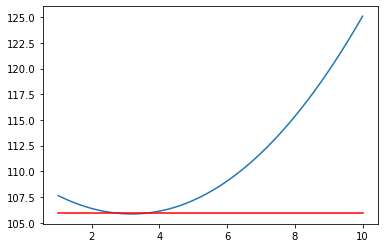

In [473]:
qs = jnp.linspace(1.01, 10, 100)
ys = np.array([phi_t(q, t, n, theta_0, v) for q in qs])
plt.plot(qs, ys)
plt.plot(qs, np.full_like(qs, bound), color='r')

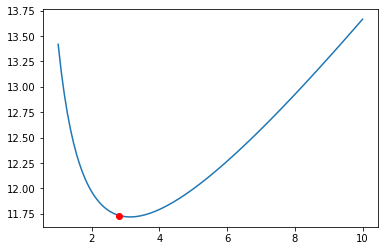

In [474]:
def objective(n, theta_0, v, a, q):
    return (A(theta_0 + q*v, n) - A(theta_0, n) + a) / q

phis = np.array([
    objective(n, theta_0, v, a, q) for q in qs
]) 
plt.plot(qs, phis)
plt.plot(q_opt, objective(n, theta_0, v, a, q_opt), 'ro')

## Optimizing q for Implicit Exponential Holder Bound

In [354]:
def objective_impl(n, theta_0, v, alpha, q):
    return (
        (A(theta_0 + q * v, n) - A(theta_0, n))
        - q * ((A(theta_0 + v, n) - A(theta_0, n)) + np.log(alpha))
    ) / (q-1)
    
def qcp_solve(n, theta_0, v, alpha):
    shift = (A(theta_0 + v, n) - A(theta_0, n)) + np.log(alpha)
    q = cp.Variable(pos=True)
    objective_fn = (
        (A_cp(theta_0 + (q+1) * v, n) - A(theta_0, n))
        - (q+1) * shift
    ) / q
    objective = cp.Minimize(objective_fn)
    problem = cp.Problem(objective)
    min = 0
    max = n * v - shift
    problem.solve(qcp=True, low=min+1e-6, high=max)
    return q.value + 1, problem.value

In [161]:
n = 350
theta_0 = -1
vs = np.linspace(0, 1, 100)
alpha = 0.025

/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


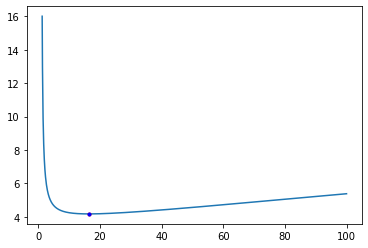

In [162]:
# cvxpy method
v = vs[2]
opt_q, opt_loss = qcp_solve(n, theta_0, v, alpha)

# brute force search method
qs = np.linspace(1.3, 100, 1000)
objs = np.array([objective(n, theta_0, v, alpha, q) for q in qs])
i_min = np.argmin(objs)

# plot
plt.plot(qs, objs)
plt.plot(qs[i_min], objs[i_min], 'r.')
plt.plot(opt_q, opt_loss, 'b.')